<a href="https://colab.research.google.com/github/JoshMcConkie/control-lab/blob/main/control-lab/maglev/MagLevBall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from scipy.optimize import differential_evolution

In [ ]:

def mag_lev_pid(Kp = 1.0, Ki = 0.0, Kd = 0.0):

    # Constants
    BALL_MASS = .01
    GRAVITY = -9.8
    Y_GOAL = -.10
    Y_INIT = -.12
    MAGNET_CONSTANT = 9.8E-4
    AMP_MAX = 100.0
    AMP_INIT = 10
    TIME_STEP = 0.01
    TIME_WINDOW = 1.0

    MAG_RESISTANCE = 5

    amperage = AMP_INIT

    y = Y_INIT
    sum_error = 0.0
    error_1 = Y_GOAL-y
    velocity = 0

    tot_energy = 0.0
    time_hist = []
    error_hist = []
    amperage_hist = []
    y_hist = []
    velocity_hist = []
    acceleration_hist = []

    for t in range(int(TIME_WINDOW/TIME_STEP)):

        # print(f'Position: {y}')

        time = t * TIME_STEP
        error = Y_GOAL - y
        sum_error += error

        #PID
        amperage = Kp*error+Ki*sum_error+Kd*(error-error_1)/TIME_STEP
        amperage = min(amperage, AMP_MAX)
        amperage = max(amperage, 0)
        mag_force = MAGNET_CONSTANT * amperage**2 / y**2
        acceleration = mag_force/BALL_MASS + GRAVITY
        # print(f'Amperage: {amperage}, Acceleration: {acceleration}')
        velocity += acceleration * TIME_STEP
        y += velocity * TIME_STEP

        error_1 = error
        tot_energy += amperage**2 * TIME_STEP


        time_hist.append(t*TIME_STEP)
        error_hist.append(error)
        amperage_hist.append(amperage)
        y_hist.append(y)
        velocity_hist.append(velocity)
        acceleration_hist.append(acceleration)

    print(f'Total Energy: {tot_energy:.2f} Joules')


    plt.figure(figsize=(12, 12))

    # 1. Height
    plt.subplot(5, 1, 1)
    plt.plot(time_hist, y_hist, label="Height")
    plt.axhline(-0.1, color='gray', linestyle='--', label="Goal Height")
    plt.ylabel("Height (m)")
    plt.legend()

    # 2. Velocity
    plt.subplot(5, 1, 2)
    plt.plot(time_hist, velocity_hist, label="Velocity", color='green')
    plt.ylabel("Velocity (m/s)")
    plt.legend()

    # 3. Acceleration
    plt.subplot(5, 1, 3)
    plt.plot(time_hist, acceleration_hist, label="Acceleration", color='purple')
    plt.ylabel("Acceleration (m/s²)")
    plt.legend()

    # 4. Amperage
    plt.subplot(5, 1, 4)
    plt.plot(time_hist, amperage_hist, label="Amperage", color='orange')
    plt.ylabel("Amperage (A)")
    plt.legend()

    # 5. Error
    plt.subplot(5, 1, 5)
    plt.plot(time_hist, error_hist, label="Error", color='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Error")
    plt.legend()


    plt.tight_layout()
    plt.show()

interact(mag_lev_pid,
  Kp=FloatSlider(value=50.0, min=0.0, max=100, step=0.1, description='Kp'),
  Ki=FloatSlider(value=0.50, min=0.0, max=8, step=0.1, description='Ki'),
  Kd=FloatSlider(value=10.0, min=0.0, max=20, step=0.1, description='Kd')
)


interactive(children=(FloatSlider(value=50.0, description='Kp'), FloatSlider(value=0.5, description='Ki', max=…

<function __main__.mag_lev_pid(Kp=1.0, Ki=0.0, Kd=0.0)>

[99.99479594  6.62318634  5.123469  ]
Optimization terminated successfully.
Iterations: 40
Evaluations: 1314
        Time to Target (s)  RMS Error  RMS Acceleration  Power Consumption ratio (×)
Value                0.210      0.034             0.012                        0.011
Weight               6.000     10.000           100.000                       10.000
Cost                 0.126      0.342             1.214                        0.109
Total Power Consumption: 1.093 J
1.7913595292654731


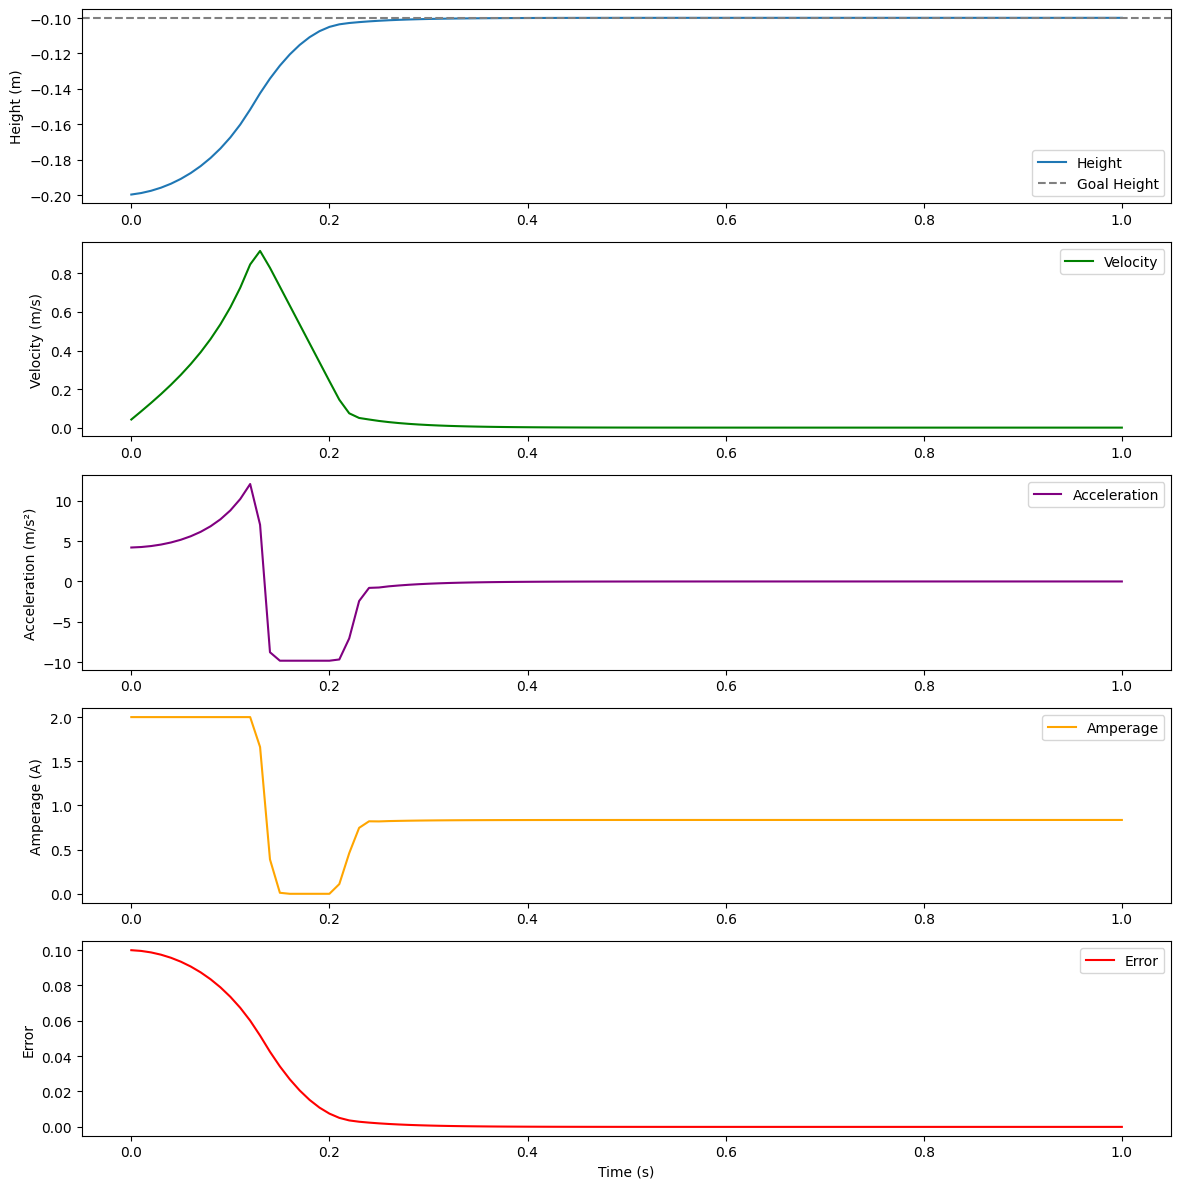

In [ ]:
from scipy.optimize import differential_evolution

# Constants
BALL_MASS = .007
GRAVITY = -9.8

Y_GOAL = -.10
Y_INIT = -.2

TIME_STEP = 0.01
TIME_WINDOW = 1.0
times = np.arange(0, TIME_WINDOW + TIME_STEP/2, TIME_STEP)

POWER_GOAL = 1 #Joules

MAGNET_CONSTANT = 9.8E-4
MAG_RESISTANCE = 5 #ohms

AMP_MAX = 2.0
AMP_INIT = 0
# below is amps need to equalize gravity at desired distance from mag
amperage_hover = abs(Y_GOAL)*np.sqrt((BALL_MASS*abs(GRAVITY)) / MAGNET_CONSTANT)

def run_mag_lev_pid(Kp = 1.0, Ki = 0.0, Kd = 0.0, hist=False):
    np.random.seed(42)


    amperage = AMP_INIT

    y = Y_INIT

    tol = .05 * abs(Y_GOAL)

    sum_error = 0.0
    error_1 = Y_GOAL-y
    de_prev = 0

    velocity = 0

    tot_energy = 0.0
    history = []

    t_to_target = None

    for time in times:
        error = Y_GOAL - y

        #Moving Avg Process to smooth things (uneccessary for magnets)
        a = 1
        de_raw = (error-error_1)/TIME_STEP
        de_smooth = a*de_raw + (1-a)*de_prev

        #PID + feed-forward
        P=Kp * error
        I=Ki * sum_error
        D=Kd * de_smooth
        ampsend_raw = amperage_hover+P+I+D

        #Clamping
        ampsend_clamp = min(max(ampsend_raw,0),AMP_MAX)

        if ampsend_clamp == ampsend_raw:
          sum_error += error*TIME_STEP
        amperage = ampsend_clamp

        if abs(y) < .01:
            return np.inf, np.inf, np.inf, np.inf, np.inf
              # kill the run immediately

        mag_force = MAGNET_CONSTANT * amperage**2 / y**2
        acceleration = mag_force/BALL_MASS + GRAVITY
        # print(f'Amperage: {amperage}, Acceleration: {acceleration}')
        velocity += acceleration * TIME_STEP
        y += velocity * TIME_STEP

        error_1 = error
        tot_energy += amperage**2 * TIME_STEP


        de_prev = de_smooth

        if t_to_target is None:
            if abs(y - Y_GOAL) < tol:
                t_to_target = time
        if np.isnan(y) or np.isnan(amperage) or np.isnan(tot_energy):
            print("Simulation blew up!")
            return np.inf, np.inf, np.inf, np.inf, np.inf
        history.append({
          'time': time,
          'height': y,
          'velocity': velocity,
          'acceleration': acceleration,
          'error': error,
          'amperage': amperage,
          'total_energy': tot_energy,
    })
    if t_to_target is None:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    df = pd.DataFrame(history)

    post_target_df = df.loc[df['time'] > t_to_target]

    if post_target_df.empty:
        # If no data after target time, assign penalty or a default value
        RMS_error = np.inf # Penalize if the ball only reaches the target at the very end
        norm_err = np.inf
        RMS_acc = 0 # No acceleration after target time if no data exists
        norm_acc = 0
    else:
        RMS_error = np.sqrt(np.mean(post_target_df['error']**2))
        norm_err = RMS_error/abs(Y_GOAL)*5

        RMS_acc = np.sqrt(np.mean(post_target_df['acceleration']**2))
        # Check if max acceleration is zero to avoid division by zero
        max_abs_acc = max(abs(post_target_df['acceleration']))
        if max_abs_acc == 0:
            norm_acc = 0
        else:
            norm_acc = RMS_acc/max_abs_acc/10

    tot_pow_cons = max(df['total_energy'])
    norm_pow_cons = tot_pow_cons/POWER_GOAL/100
    # RMS_amperage = np.sqrt(post_m_amperage)

    # print(f'Post Target Variance: {post_variance:.2f}')
    # print(f'Post Target Acceleration: {post_acceleration:.2f}')
    # print(f'Post Target Error: {post_error:.2f}')
    # print(f'Post Target Amperage: {post_m_amperage:.2f}')
    # print(f'Total Power Consumed: {tot_pow_cons:.2f}')


    # if hits==True, show graphs of the key signals
    if hist:
        plt.figure(figsize=(12, 12))

        # 1. Height
        plt.subplot(5, 1, 1)
        plt.plot(df['time'], df['height'], label="Height")
        plt.axhline(Y_GOAL, color='gray', linestyle='--', label="Goal Height")
        plt.ylabel("Height (m)")
        plt.legend()

        # 2. Velocity
        plt.subplot(5, 1, 2)
        plt.plot(df['time'], df['velocity'], label="Velocity", color='green')
        plt.ylabel("Velocity (m/s)")
        plt.legend()

        # 3. Acceleration
        plt.subplot(5, 1, 3)
        plt.plot(df['time'], df['acceleration'], label="Acceleration", color='purple')
        plt.ylabel("Acceleration (m/s²)")
        plt.legend()

        # 4. Amperage
        plt.subplot(5, 1, 4)
        plt.plot(df['time'], df['amperage'], label="Amperage", color='orange')
        plt.ylabel("Amperage (A)")
        plt.legend()

        # 5. Error
        plt.subplot(5, 1, 5)
        plt.plot(df['time'], df['error'], label="Error", color='red')
        plt.xlabel("Time (s)")
        plt.ylabel("Error")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return t_to_target, norm_err, norm_acc, norm_pow_cons, tot_pow_cons


def cost(params,w_time=6, w_acc=100, w_err=10, w_pow=10, disp=False):
    Kp,Ki,Kd = params
    t_to_target, norm_err, norm_acc, norm_pow_cons, tot_pow_cons = run_mag_lev_pid(Kp,Ki,Kd)
    if any(np.isnan(x) or np.isinf(x) for x in [t_to_target, norm_err, norm_acc, norm_pow_cons, tot_pow_cons]):
      return 1e60  # large penalty value

    time_cost = w_time * t_to_target/TIME_WINDOW/10
    err_cost = w_err * norm_err
    acc_cost = w_acc * norm_acc
    pow_cost = w_pow * norm_pow_cons

    cost = time_cost + err_cost + acc_cost + pow_cost
    if disp:
        data = {
            'Time to Target (s)':   [t_to_target,      w_time, time_cost],
            'RMS Error':             [norm_err,         w_err,  err_cost],
            'RMS Acceleration':      [norm_acc,         w_acc,  acc_cost],
            'Power Consumption ratio (×)': [norm_pow_cons,    w_pow,  pow_cost]
        }
        df_metrics = pd.DataFrame(data, index=['Value','Weight','Cost'])
        print(df_metrics.round(3).to_string())

        # Optionally print the grand total
        print(f"Total Power Consumption: {tot_pow_cons:.3f} J")
        # print(f"\nTotal Cost: {cost:.3f}")
    return cost


Kp_bounds = (0, 100)
Ki_bounds = (0, 8)
Kd_bounds = (0, 20)
bounds = [Kp_bounds, Ki_bounds, Kd_bounds]

optimized = differential_evolution(
    cost, bounds,
    # disp=True,
    maxiter=1000,         # reduce from default 1000
    popsize=10,         # reduce from default 15
    tol=1e-3,           # slightly looser tolerance
    seed=42
)

print(optimized.x)
# print(optimized.fun)
# print(optimized.success)
print(optimized.message)
print(f"Iterations: {optimized.nit}")
print(f"Evaluations: {optimized.nfev}")

print(cost(optimized.x, disp=True))
run_mag_lev_pid(*optimized.x,hist=True)

optimal= [87.9883187, 8, 2.66658763]


Total Energy: 1.03 Joules


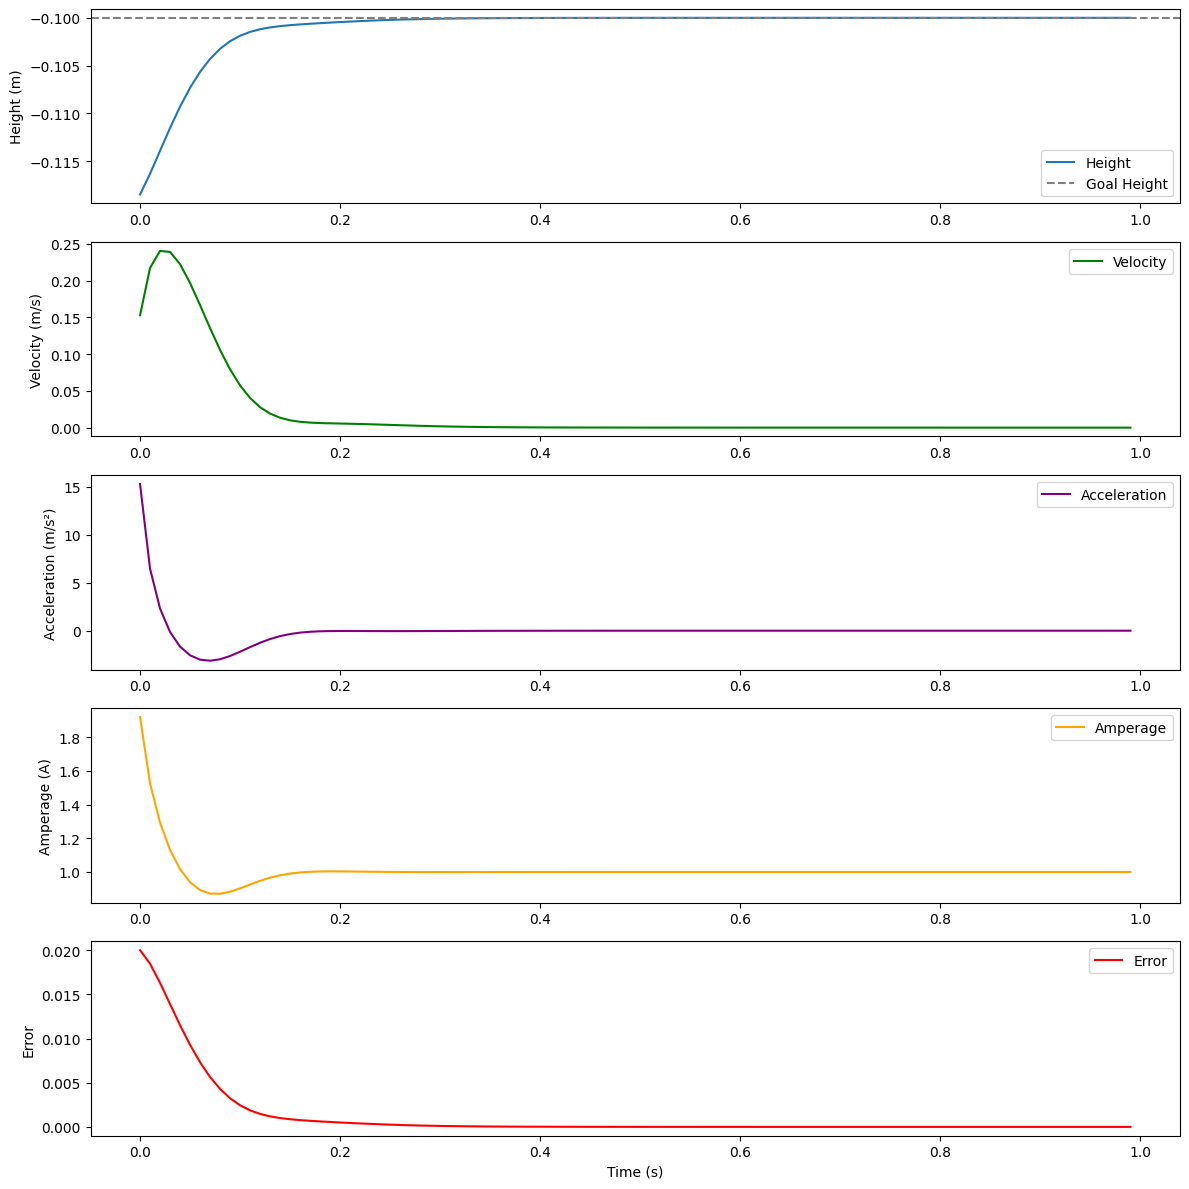

In [ ]:
mag_lev_pid(*optimal)